# Configs and Imports

In [1]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import gc

warnings.filterwarnings('ignore')

In [2]:
TARGET = 'Response'
N_FOLDS = 5
SEED = 90
ES_ROUNDS = 150
ES_LOG_STEPS = 500

TRAIN_PATH = '/kaggle/input/playground-series-s4e7/train.csv'
TEST_PATH = '/kaggle/input/playground-series-s4e7/test.csv'
ORIGINAL_PATH = '/kaggle/input/health-insurance-cross-sell-prediction-data/train.csv'

# Loading and Processing The Datasets

In [3]:
class DataLoader:
    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path

    @staticmethod
    def encode_categorical_features(dataframe):  
        print('--- Encoding categorical features')
        
        gender_mapping = {'Male': 0, 'Female': 1}
        vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
        vehicle_damage_mapping = {'No': 0, 'Yes': 1}
        
        dataframe['Gender'] = dataframe['Gender'].map(gender_mapping)
        dataframe['Vehicle_Age'] = dataframe['Vehicle_Age'].map(vehicle_age_mapping)
        dataframe['Vehicle_Damage'] = dataframe['Vehicle_Damage'].map(vehicle_damage_mapping)
        
        return dataframe
    
    @staticmethod
    def convert_data_types(dataframe):  
        print('--- Converting data types')
        
        dataframe['Region_Code'] = dataframe['Region_Code'].astype(int) 
        dataframe['Annual_Premium'] = dataframe['Annual_Premium'].astype(int) 
        dataframe['Policy_Sales_Channel'] = dataframe['Policy_Sales_Channel'].astype(int) 
        
        return dataframe
    
    @staticmethod
    def add_features(dataframe):  
        print("--- Adding new features")
        # Reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution
        # Beware of data leakage
        dataframe['Previously_Insured_Annual_Premium'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Annual_Premium'].astype(str))[0]
        dataframe['Previously_Insured_Vehicle_Age'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vehicle_Age'].astype(str))[0]
        dataframe['Previously_Insured_Vehicle_Damage'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vehicle_Damage'].astype(str))[0]
        dataframe['Previously_Insured_Vintage'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vintage'].astype(str))[0]
        
        return dataframe
    
    @staticmethod
    def reduce_mem_usage(dataframe):
        # Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516103#2899151
        
        print('--- Reducing memory usage')
        initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
        
        for col in dataframe.columns:
            col_type = dataframe[col].dtype

            if col_type.name in ['category', 'object']:
                raise ValueError(f"Column '{col}' is of type '{col_type.name}'")

            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

        final_mem_usage = dataframe.memory_usage().sum() / 1024**2
        print('------ Memory usage before: {:.2f} MB'.format(initial_mem_usage))
        print('------ Memory usage after: {:.2f} MB'.format(final_mem_usage))
        print('------ Decreased memory usage by {:.1f}%'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

        return dataframe

    @staticmethod
    def reflip_flipped_targets(train_df):
        # Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/520253
        original_df = pd.read_csv(ORIGINAL_PATH, index_col="id")

        train_df["is_original"] = False
        original_df["is_original"] = True
        combined = pd.concat([train_df, original_df], axis=0)

        duplicates = combined.duplicated(subset=combined.columns[:-2], keep=False)
        duplicates = duplicates[duplicates].index

        combined.loc[duplicates, TARGET] = 1 - combined.loc[duplicates, TARGET]
        train_df = combined[~combined["is_original"]].drop(columns="is_original")

        del original_df, combined, duplicates
        gc.collect()

        return train_df

    def load(self):
        print(f'Loading data')
        
        train = pd.read_csv(self.train_path, index_col='id')
        test = pd.read_csv(self.test_path, index_col='id')
        
        train = self.reflip_flipped_targets(train)
        
        train['is_train'] = 1
        test['is_train'] = 0
        dataframe = pd.concat([train, test])
        del train, test
        gc.collect()
        
        dataframe = self.encode_categorical_features(dataframe)
        dataframe = self.convert_data_types(dataframe)
        dataframe = self.add_features(dataframe)
        dataframe = self.reduce_mem_usage(dataframe)
        
        train = dataframe[dataframe['is_train'] == 1].drop(columns=['is_train'])
        test = dataframe[dataframe['is_train'] == 0].drop(columns=['is_train', TARGET])
        
        del dataframe
        gc.collect()
        
        train[TARGET] = train[TARGET].astype(np.int8)
        
        return train, test

In [4]:
train, test = DataLoader(TRAIN_PATH, TEST_PATH).load()

X = train.drop(columns=TARGET)
y = train[TARGET]

Loading data
--- Encoding categorical features
--- Converting data types
--- Adding new features
--- Reducing memory usage
------ Memory usage before: 2486.95 MB
------ Memory usage after: 621.74 MB
------ Decreased memory usage by 75.0%


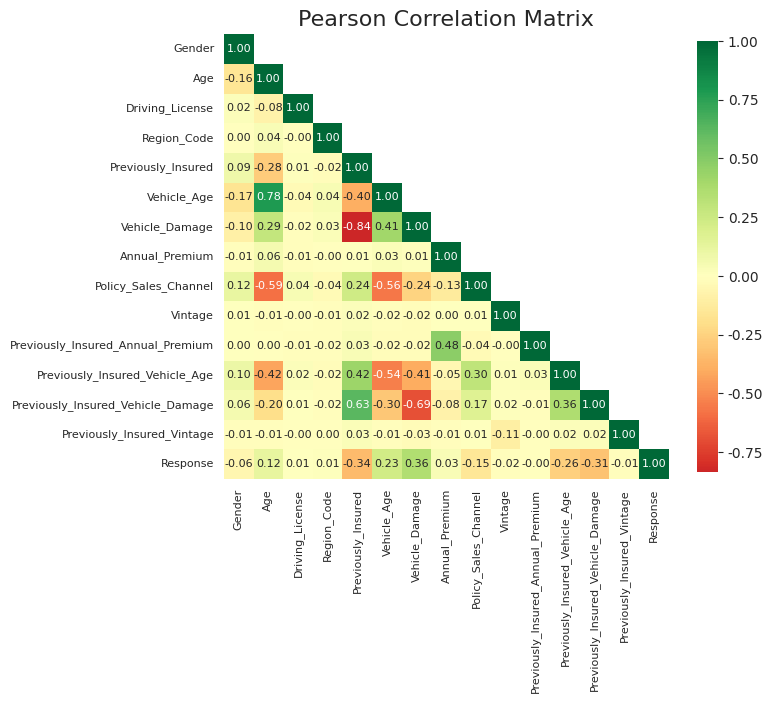

15

In [5]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 8))

cols = list(X.columns) + [TARGET]
temp_train = train[cols]

corr_train = temp_train.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)
sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='RdYlGn',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax 
)

ax.set_title('Pearson Correlation Matrix', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

del temp_train, corr_train, mask_train
gc.collect()

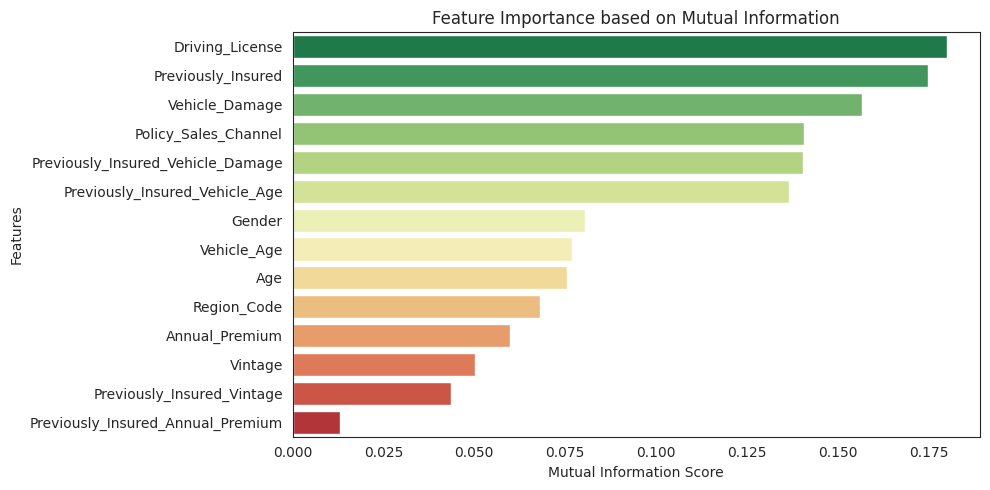

5650

In [6]:
train_mi = train.copy()
train_mi = train_mi.sample(1000_000)
X_mi = train_mi.drop(columns=TARGET)
y_mi = train_mi[TARGET]

mutual_info = mutual_info_classif(X_mi, y_mi, random_state=SEED)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])

plt.figure(figsize=(10, 5))
sns.barplot(x=mutual_info['Mutual Information'], y=mutual_info.index, palette='RdYlGn_r')
plt.title('Feature Importance based on Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

del train_mi, X_mi, y_mi
gc.collect()

# Training

In [7]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []
        feature_importances = np.zeros(X.shape[1])
        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        test_preds = []
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            train_pool = Pool(X_train, y_train, cat_features=X_train.columns.values)
            val_pool = Pool(X_val, y_val, cat_features=X_val.columns.values)
            test_pool = Pool(X_test, cat_features=X_test.columns.values)
            
            model = clone(self.model)
            model.fit(
                X=train_pool, 
                eval_set=val_pool, 
                verbose=ES_LOG_STEPS, 
                early_stopping_rounds=ES_ROUNDS,
                use_best_model=True
            )
            
            feature_importances += model.feature_importances_ / self.n_folds
            
            y_pred_probs = model.predict_proba(val_pool)
            oof_pred_probs[val_idx] = y_pred_probs            
            
            temp_test_pred_probs = model.predict_proba(test_pool)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            test_preds.append(temp_test_pred_probs[:, 1])
            
            score = roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs, temp_test_pred_probs, train_pool, val_pool, test_pool
            gc.collect()
            
            print(f'\n--- Fold {fold_idx + 1} - AUC: {score:.5f}\n\n')
            
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        self._save_submission(test_preds, np.mean(scores))
        
        gc.collect()
        
        print(f'------ Average AUC:      {np.mean(scores):.5f} ± {np.std(scores):.5f}\n\n')

        return oof_pred_probs, scores, feature_importances
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{model_name}_{name}_pred_probs_{cv_score:.5f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)
    
    def _save_submission(self, test_preds, score):
        sub = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
        
        sub['id'] = sub['id']
        sub[TARGET] = np.mean(test_preds, axis=0)
        
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub.to_csv(f'sub_{name}_{score:.5f}.csv', index=False)

In [8]:
model = CatBoostClassifier(
    # Reference: https://www.kaggle.com/code/ivanmitriakhin/5-fold-catboost-cv-0-89485-lb-0-89629
    loss_function='Logloss',
    eval_metric='AUC',
    class_names=[0, 1],
    learning_rate=0.075,
    iterations=5000,
    depth=9,
    random_strength=0,
    l2_leaf_reg=0.5,
    max_leaves=512,
    fold_permutation_block=64,
    task_type='GPU',
    random_seed=SEED,
    verbose=False
)
trainer = Trainer(model)
oof_pred_probs, scores, feature_importances = trainer.fit_predict(X, y, test)

Training CatBoostClassifier



Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8736852	best: 0.8736852 (0)	total: 8.92s	remaining: 12h 22m 54s
500:	test: 0.8922960	best: 0.8922960 (500)	total: 8m 45s	remaining: 1h 18m 35s
1000:	test: 0.8927393	best: 0.8927395 (997)	total: 17m 21s	remaining: 1h 9m 21s
1500:	test: 0.8928750	best: 0.8928750 (1500)	total: 25m 58s	remaining: 1h 32s
2000:	test: 0.8929543	best: 0.8929543 (2000)	total: 34m 29s	remaining: 51m 40s
bestTest = 0.8929849267
bestIteration = 2233
Shrink model to first 2234 iterations.

--- Fold 1 - AUC: 0.89298




Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8728319	best: 0.8728319 (0)	total: 992ms	remaining: 1h 22m 40s
500:	test: 0.8923149	best: 0.8923149 (500)	total: 8m 38s	remaining: 1h 17m 34s
1000:	test: 0.8927312	best: 0.8927312 (1000)	total: 17m 16s	remaining: 1h 9m 2s
1500:	test: 0.8928840	best: 0.8928863 (1489)	total: 25m 52s	remaining: 1h 17s
2000:	test: 0.8929442	best: 0.8929446 (1995)	total: 34m 27s	remaining: 51m 38s
2500:	test: 0.8929694	best: 0.8929695 (2498)	total: 43m 2s	remaining: 43m
bestTest = 0.8929739594
bestIteration = 2559
Shrink model to first 2560 iterations.

--- Fold 2 - AUC: 0.89297




Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8732631	best: 0.8732631 (0)	total: 906ms	remaining: 1h 15m 27s
500:	test: 0.8920136	best: 0.8920137 (499)	total: 8m 39s	remaining: 1h 17m 49s
1000:	test: 0.8924278	best: 0.8924278 (1000)	total: 17m 13s	remaining: 1h 8m 47s
1500:	test: 0.8925840	best: 0.8925840 (1500)	total: 25m 51s	remaining: 1h 15s
2000:	test: 0.8926585	best: 0.8926601 (1977)	total: 34m 22s	remaining: 51m 30s
bestTest = 0.8926718831
bestIteration = 2290
Shrink model to first 2291 iterations.

--- Fold 3 - AUC: 0.89267




Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8732522	best: 0.8732522 (0)	total: 905ms	remaining: 1h 15m 25s
500:	test: 0.8921202	best: 0.8921202 (500)	total: 8m 43s	remaining: 1h 18m 16s
1000:	test: 0.8925708	best: 0.8925708 (1000)	total: 17m 17s	remaining: 1h 9m 5s
1500:	test: 0.8927301	best: 0.8927301 (1500)	total: 25m 53s	remaining: 1h 20s
2000:	test: 0.8928127	best: 0.8928130 (1999)	total: 34m 29s	remaining: 51m 41s
2500:	test: 0.8928198	best: 0.8928242 (2350)	total: 43m 4s	remaining: 43m 2s
bestTest = 0.892824173
bestIteration = 2350
Shrink model to first 2351 iterations.

--- Fold 4 - AUC: 0.89282




Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8735698	best: 0.8735698 (0)	total: 1.05s	remaining: 1h 27m 50s
500:	test: 0.8920534	best: 0.8920534 (500)	total: 8m 36s	remaining: 1h 17m 21s
1000:	test: 0.8924696	best: 0.8924696 (1000)	total: 17m 12s	remaining: 1h 8m 45s
1500:	test: 0.8926162	best: 0.8926162 (1500)	total: 25m 48s	remaining: 1h 9s
2000:	test: 0.8926687	best: 0.8926689 (1999)	total: 34m 22s	remaining: 51m 31s
2500:	test: 0.8926880	best: 0.8926894 (2410)	total: 42m 54s	remaining: 42m 52s
bestTest = 0.8926894069
bestIteration = 2410
Shrink model to first 2411 iterations.

--- Fold 5 - AUC: 0.89269


------ Average AUC:      0.89283 ± 0.00013




# Visualizing The Results

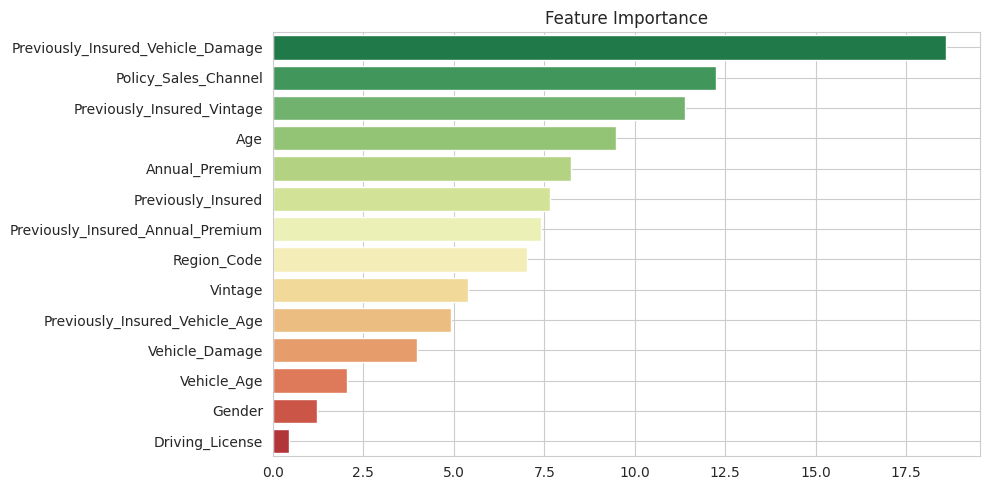

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))

fi = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
sns.barplot(
    y=fi.index, 
    x=fi.values, 
    orient='h', 
    palette=sns.color_palette('RdYlGn_r', len(X.columns))
)
plt.title('Feature Importance')
plt.grid(True)

plt.tight_layout()
plt.show()

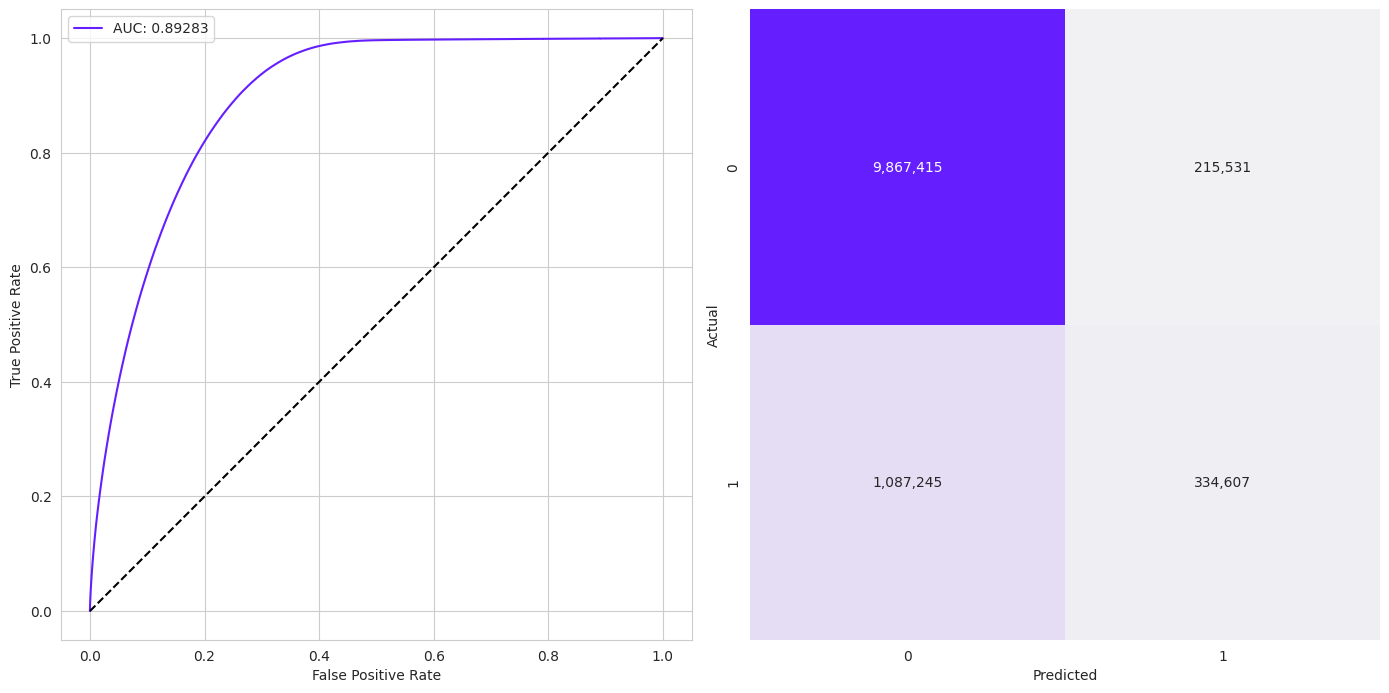

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, _ = roc_curve(y, oof_pred_probs[:, 1])
axes[0].plot(fpr, tpr, label=f'AUC: {np.mean(scores):.5f}', color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

y_pred = oof_pred_probs.argmax(axis=1)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt=',', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()